## This notebook will reproduce Figure 5 in the publication "A NWB-based Dataset and Processing Pipeline of Human Single-Neuron Activity During a Declarative Memory Task" by Chandravadia N. et al. 

#### *Note: Running the code might take some time (about 5 min) -- (due to reading from and extracting data from the NWB files)*

* Author: [Nand Chandravadia](mailto:nandc10@ucla.edu)

In [1]:
#Figure 5 (Plot) 

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pandas as pd
import os
import sys
from pynwb import NWBHDF5IO
import matplotlib.pyplot as plt
import seaborn as sns
import RutishauserLabtoNWB.events.newolddelay.python.analysis.helper as helper
import RutishauserLabtoNWB.events.newolddelay.python.analysis.single_neuron as single_neuron
import configparser

sns.set(style="ticks", color_codes=True)

C:\Users\chandravadn1\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# =====================================
#Specfify where the NWB files are
NWBFilePath = 'V:\\LabUsers\\chandravadian\\NWB Data\\test\\'
# ===================================

In [3]:

#initialze the ConfigParser() class
config = configparser.ConfigParser()

#Get the path to the configuration file
subjects_ini = os.path.join(os.path.dirname(os.path.dirname(os.path.dirname(single_neuron.__file__))),
                                'defineNOsessions_release.ini')

filename = subjects_ini
#Read the config file
try:
    config.read(filename)
    #print ('This file was successfully read: {}\n'.format(filename))
except:
    print ('Failed to read the config file..')
    print ('Does this file exist: {}'.format(os.path.exists(filename)))


#Read the headers of the configuration file
allSessions = config.sections()    

dataDirectory = NWBFilePath

totalNeurons = {} 
totalVSNeurons = {}
totalMSNeurons = {}
totaldualNeurons = {}
aucAll = {}
stats_all_X = np.zeros((len(allSessions), 7))
stats_all_Y = np.zeros((len(allSessions), 7))
accuracies_high = {}
accuracies_low = {}

index = 0

for session in allSessions:
    
    session_file = helper.getpatientfile_fromINIfile(session, dataDirectory) # Session file = .nwb file

    neurons = []
    # Get neurons from nwbfile
    try:
        nwbfile = helper.read(session_file)
    except ValueError as e:
        raise Exception('Problem opening the file: {}', str(e))
        continue
    try:
        temp = single_neuron.extract_neuron_data_from_nwb(nwbfile)
    except IndexError as e:
        raise Exception("Somehow catch this index error: {}", str(e))
        continue
        
    #Compute the AUC
    stats_all = helper.cal_cumulative_d(nwbfile)
    auc = helper.cal_auc(stats_all)
    
    # Find visually selective (VS) neurons and memory selective (MS) neurons
    neurons = neurons + temp
    vs_neurons = []
    ms_neurons = []
    dual_neurons = []

    for neuron in neurons:
        print('Processing..: ', str(neuron.session_id) + ' ', str(neuron.channel_id),' ', str(neuron.neuron_id))
        if neuron.vs_test() < 0.05:
            vs_neurons.append(neuron)
        if neuron.ms_test(1000) < 0.05:
            ms_neurons.append(neuron)
        if (neuron.vs_test() < 0.05) & (neuron.ms_test(1000) < 0.05): 
            dual_neurons.append(neuron)
            
    totalNeurons[session] = neurons
    totalVSNeurons[session] = vs_neurons
    totalMSNeurons[session] = ms_neurons
    totaldualNeurons[session] = dual_neurons
    aucAll[session] = auc
    
    
    x = stats_all[0:5, 4]
    y = stats_all[0:5, 3]
    
    x = np.insert(x, 0, 0)
    x = np.append(x, 1)
    y = np.insert(y, 0, 0)
    y = np.append(y, 1)
    
    stats_all_X[index] = x
    stats_all_Y[index] = y
    
    index += 1

    
    #Get percent accuracy for each High and Low Confidence

    recog_response = helper.extract_recog_responses(nwbfile)
    is_included = helper.check_inclusion(recog_response, auc)
    
    if is_included:
        ground_truth = helper.extract_new_old_label(nwbfile)
        split_status, split_mode, ind_TP_high, ind_TP_low, ind_FP_high, ind_FP_low, ind_TN_high, \
        ind_TN_low, ind_FN_high, ind_FN_low, n_response = helper.dynamic_split(recog_response, ground_truth)
        
        nr_TN_high = len(ind_TN_high[0])
        nr_TP_high = len(ind_TP_high[0])
        nr_TN_all = len(ind_TN_high[0]) + len(ind_TN_low[0])
        nr_TN_low = len(ind_TP_high[0]) + len(ind_TP_low[0])
        nr_TP_low = len(ind_TP_low[0])
        nr_TN_low = len(ind_TN_low[0])

        nr_high_response = len(ind_TN_high[0]) + len(ind_TP_high[0]) + len(ind_FN_high[0]) + len(ind_FP_high[0])
        nr_low_response = len(ind_TN_low[0]) + len(ind_TP_low[0]) + len(ind_FN_low[0]) + len(ind_FP_low[0])
    
        per_accuracy_high = (nr_TN_high + nr_TP_high) / nr_high_response
        per_accuracy_low = (nr_TN_low + nr_TP_low) / nr_low_response

        accuracies_high[session] = (per_accuracy_high*100)
        accuracies_low[session] = (per_accuracy_low*100)

Session_id:  H09_5
Channel:  1
Cell_id:  0
Number of spikes: 573
Session_id:  H09_5
Channel:  2
Cell_id:  1
Number of spikes: 298
Session_id:  H09_5
Channel:  2
Cell_id:  1
Number of spikes: 5547
Session_id:  H09_5
Channel:  3
Cell_id:  2
Number of spikes: 4596
Session_id:  H09_5
Channel:  4
Cell_id:  3
Number of spikes: 2859
Session_id:  H09_5
Channel:  4
Cell_id:  3
Number of spikes: 446
Session_id:  H09_5
Channel:  5
Cell_id:  4
Number of spikes: 4129
Session_id:  H09_5
Channel:  7
Cell_id:  5
Number of spikes: 1125
Session_id:  H09_5
Channel:  8
Cell_id:  6
Number of spikes: 614
Session_id:  H09_5
Channel:  8
Cell_id:  6
Number of spikes: 8023
Session_id:  H09_5
Channel:  18
Cell_id:  7
Number of spikes: 642
Session_id:  H09_5
Channel:  18
Cell_id:  7
Number of spikes: 1881
Session_id:  H09_5
Channel:  19
Cell_id:  8
Number of spikes: 4090
Session_id:  H09_5
Channel:  19
Cell_id:  8
Number of spikes: 531
Session_id:  H09_5
Channel:  20
Cell_id:  9
Number of spikes: 9418
Session_id:

C:\Users\chandravadn1\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:2933: RuntimeWarning: invalid value encountered in double_scalars
  f = msb / msw


Processing..:  H18_26  31   949
Processing..:  H18_26  31   951
Processing..:  H18_26  31   1036
Processing..:  H18_26  31   1134
Processing..:  H18_26  31   1145
Processing..:  H18_26  43   638
Processing..:  H18_26  46   775
Session_id:  H19_27
Channel:  15
Cell_id:  0
Number of spikes: 465
Session_id:  H19_27
Channel:  15
Cell_id:  0
Number of spikes: 914
Session_id:  H19_27
Channel:  15
Cell_id:  0
Number of spikes: 6797
Session_id:  H19_27
Channel:  26
Cell_id:  1
Number of spikes: 776
Session_id:  H19_27
Channel:  26
Cell_id:  1
Number of spikes: 5011
Session_id:  H19_27
Channel:  26
Cell_id:  1
Number of spikes: 778
Session_id:  H19_27
Channel:  28
Cell_id:  2
Number of spikes: 1224
Session_id:  H19_27
Channel:  28
Cell_id:  2
Number of spikes: 576
Session_id:  H19_27
Channel:  28
Cell_id:  2
Number of spikes: 994
Session_id:  H19_27
Channel:  29
Cell_id:  3
Number of spikes: 82
Session_id:  H19_27
Channel:  29
Cell_id:  3
Number of spikes: 1535
Session_id:  H19_27
Channel:  29


C:\Users\chandravadn1\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'High vs. Low Confidence')

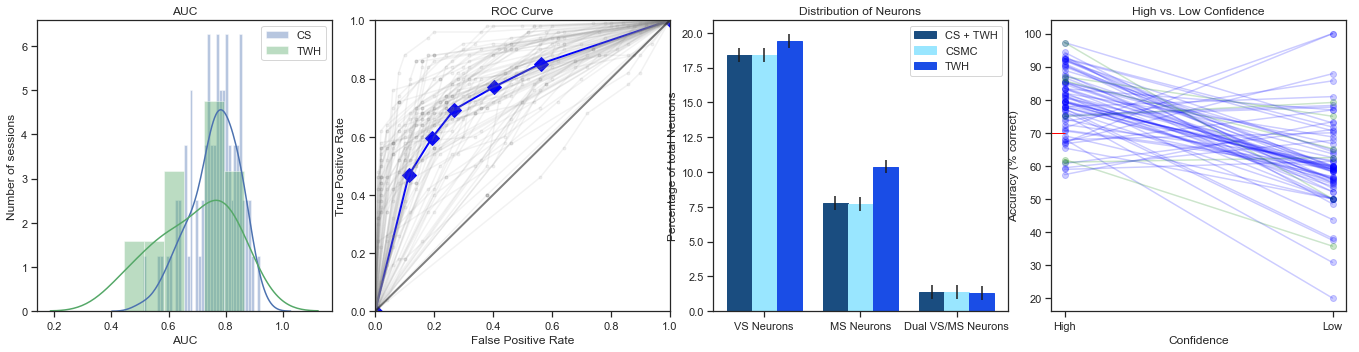

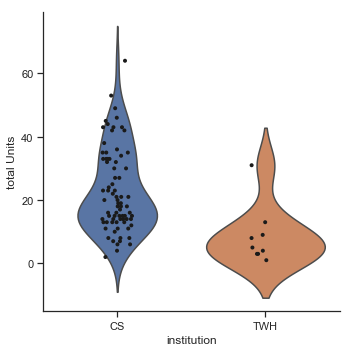

In [67]:
#Plotting 

fig, axes = plt.subplots(1,4, figsize = (19, 5))


# ========== Subplot  (Plot AUC Histogram) ===============

allSessions = np.array([int(i) for i in list(aucAll.keys())])
CSsessions = allSessions[np.where(np.array(allSessions) < 2000)[0]]
TWHsessions = allSessions[np.where(np.array(allSessions) > 2000)[0]]

allCS_auc = []
allTWH_auc = []
for i in CSsessions: 
    allCS_auc.append(aucAll[str(i)])
for i in TWHsessions: 
    allTWH_auc.append(aucAll[str(i)])

#Plot (Figure 5)

sns.distplot(allCS_auc, bins = 40, color = 'b', label = 'CS', ax = axes[0])
sns.distplot(allTWH_auc, bins = 6,color = 'g', label = 'TWH', ax = axes[0])
axes[0].set_ylabel('Number of sessions')
axes[0].set_xlabel('AUC')
axes[0].set_title('AUC')
axes[0].legend()
plt.tight_layout()



# ================= Subplot (Units) =============================
allSessions = np.array([int(i) for i in list(totalNeurons.keys())])
CSsessions = allSessions[np.where(np.array(allSessions) < 2000)[0]]
TWHsessions = allSessions[np.where(np.array(allSessions) > 2000)[0]]

allCSNeurons = []
allTWHNeurons = []
for i in CSsessions: 
    allCSNeurons.append(len(totalNeurons[str(i)]))
    
for i in TWHsessions: 
    allTWHNeurons.append(len(totalNeurons[str(i)]))


#Concatnate into List (both institutions)
CS_inst = ['CS']*len(allCSNeurons)
TWH_inst = ['TWH']*len(allTWHNeurons)
all_inst = CS_inst + TWH_inst

a = {'institution': all_inst, "total Units": allCSNeurons+allTWHNeurons}
tips2 = pd.DataFrame(a)


sns.catplot(x="institution", y="total Units", data=tips2, kind = 'violin', inner = None, edgecolor = 'none')
sns.stripplot(x="institution", y="total Units", color="k", size=4, data=tips2, edgecolor = 'none', jitter = True)

# ==================== Subplot (ROC) ==================

mean_X = np.mean(stats_all_X, axis = 0)
mean_Y = np.mean(stats_all_Y, axis = 0)

axes[1].plot(mean_X, mean_Y, color='blue', alpha=1, linewidth=2, markersize=10, marker = 'D')
for i in range(0,len(stats_all_X)):
    axes[1].plot(stats_all_X[i], stats_all_Y[i], color = 'grey', alpha=0.1, marker = '.')
axes[1].set_ylim(0, 1)
axes[1].set_xlim(0, 1)
axes[1].set_title('ROC Curve')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].plot([0, 1], [0, 1], color='black', alpha=0.5, linewidth=2)



# =================== Subplot ================================
percent_cells_CSMC, ticks_CSMC = (18.4, 7.7, 1.4), (.5, .5, .5)
percent_cells_TWH, ticks_TWH = (19.4, 10.4, 1.3), (.5, .5, .5)
percent_cells_All, ticks_All = (18.4, 7.8, 1.4), (.5, .5, .5)
colors = [[.1, .3, .5], [.6, .9, 1], [.1, .3, .7], [.1, .3, .9]]

ind = np.arange(len(percent_cells_CSMC))  # the x locations for the groups
width = 0.26  # the width of the bars

rects3 = axes[2].bar(ind - (width), percent_cells_All, width, yerr=ticks_All,
                label='CS + TWH', Color = colors[0])
rects1 = axes[2].bar(ind, percent_cells_CSMC, width, yerr=ticks_CSMC,
                label='CSMC', Color = colors[1])
rects2 = axes[2].bar(ind + (width), percent_cells_TWH, width, yerr=ticks_TWH,
                label='TWH', Color = colors[3])


# Add some text for labels, title and custom x-axis tick labels, etc.
axes[2].set_ylabel('Percentage of total Neurons')
axes[2].set_title('Distribution of Neurons')
axes[2].set_xticks(ind)
axes[2].set_xticklabels(('VS Neurons', 'MS Neurons', 'Dual VS/MS Neurons'))
axes[2].legend()


# ============== Subplot ================================
allSessions = np.array([int(i) for i in list(accuracies_high.keys())])
CSsessions = allSessions[np.where(np.array(allSessions) < 2000)[0]]
TWHsessions = allSessions[np.where(np.array(allSessions) > 2000)[0]]


CS_high_confidence = []
CS_low_confidence = []
TWH_high_confidence = []
TWH_low_confidence = []

for i in CSsessions: 
    CS_high_confidence.append(accuracies_high[str(i)])
    CS_low_confidence.append(accuracies_low[str(i)])
     
for i in TWHsessions: 
    TWH_high_confidence.append(accuracies_high[str(i)])
    TWH_low_confidence.append(accuracies_low[str(i)])
  
x_axis = ['High', 'Low']
x_axis2 = ['High']
axes[3].plot(x_axis, [CS_high_confidence[:], CS_low_confidence[:]], marker='o', color = 'blue', alpha = .2)
axes[3].plot(x_axis, [TWH_high_confidence[:], TWH_low_confidence[:]], marker = 'o', color = 'green', alpha = .2)
axes[3].plot(x_axis2, [70], 's', marker = 0, color = 'red', markersize = 20)
axes[3].set_xlabel('Confidence')
axes[3].set_ylabel('Accuracy (% correct)')
axes[3].set_title('High vs. Low Confidence')

